# Data Processing Template
This notebook was used to download, analyze and process the data from the NOAA Pudget Sound dataset.

You can use this template to process your own dataset.

In [1]:
import matplotlib.pyplot as plt
import supervision as sv
from pathlib import Path
import random
import os
import glob
import xml.etree.ElementTree as ET
import json
import cv2
import numpy as np

## Download the Data
- If you want to use the `unzip` command you might need to install it. On linux, run `sudo apt-get install unzip`

In [2]:
dataset_shortname = "fishclef"
data_dir = Path("/tmp/data/") / dataset_shortname
data_dir.mkdir(exist_ok=True, parents=True)

In [3]:
data = "https://bit.ly/fishclef-2015"
data_path = data_dir / "data.zip"
!wget -O {data_path} {data}

--2025-02-16 10:47:45--  https://bit.ly/fishclef-2015
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://studentiunict-my.sharepoint.com/:u:/g/personal/simone_palazzo_unict_it/EWDSc51TFkdDkx3lKms0lykBppjKn4GMOsOvqVVIOa7MoQ?e=tH6NrD [following]
--2025-02-16 10:47:45--  https://studentiunict-my.sharepoint.com/:u:/g/personal/simone_palazzo_unict_it/EWDSc51TFkdDkx3lKms0lykBppjKn4GMOsOvqVVIOa7MoQ?e=tH6NrD
Resolving studentiunict-my.sharepoint.com (studentiunict-my.sharepoint.com)... 13.107.136.10, 13.107.138.10
Connecting to studentiunict-my.sharepoint.com (studentiunict-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://studentiunict-my.sharepoint.com/personal/simone_palazzo_unict_it/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fsimone%5Fpalazzo%5Funict%5Fit%2FDocuments%2FDatas

In [5]:
!unzip {data_path} -d {data_dir}

Archive:  /tmp/data/fishclef/data.zip
   creating: /tmp/data/fishclef/fishclef_2015_release/
   creating: /tmp/data/fishclef/fishclef_2015_release/training_set/
   creating: /tmp/data/fishclef/fishclef_2015_release/training_set/species_samples/
   creating: /tmp/data/fishclef/fishclef_2015_release/training_set/species_samples/Acanthurus nigrofuscus/
  inflating: /tmp/data/fishclef/fishclef_2015_release/training_set/species_samples/Acanthurus nigrofuscus/sample2305.png  
  inflating: /tmp/data/fishclef/fishclef_2015_release/training_set/species_samples/Acanthurus nigrofuscus/sample1145.png  
  inflating: /tmp/data/fishclef/fishclef_2015_release/training_set/species_samples/Acanthurus nigrofuscus/sample1750.png  
  inflating: /tmp/data/fishclef/fishclef_2015_release/training_set/species_samples/Acanthurus nigrofuscus/sample1441.png  
  inflating: /tmp/data/fishclef/fishclef_2015_release/training_set/species_samples/Acanthurus nigrofuscus/sample1123.png  
  inflating: /tmp/data/fishclef/f

In [3]:
training_annotations_path = "/tmp/data/fishclef/fishclef_2015_release/training_set/gt"
training_annotations_coco_path = "/tmp/data/fishclef/fishclef_2015_release/training_set/gt_coco"
training_videos_path = "/tmp/data/fishclef/fishclef_2015_release/training_set/videos"

### Clean the annotations
Turn into COCO format readable by `supervision` library, for easy visualization and conversion to other formats.
- one "video".json is created per video
- "video".json only contains annotations for images with at least one bounding box

In [4]:
def convert_xml_to_coco(xml_file, output_dir=None):
    """
    Converts a single XML annotation file to COCO JSON format.
    
    Parameters:
        xml_file (str): Path to the XML file.
        output_dir (str): Directory where the JSON file will be saved. 
                          If None, the JSON is saved in the same directory as xml_file.
        width (int): Default image width.
        height (int): Default image height.
    
    Returns:
        output_json (str): Path to the generated COCO JSON file.
    """
    # Parse XML
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Extract the video id/name from the <video> element.
    video_id = root.get("id")

    images = []
    annotations = []
    categories = {}
    ann_id = 1

    # Process each <frame> element
    for frame in root.findall("frame"):
        frame_id = frame.get("id")
        # Create image entry; using the video id and frame id in the file name.
        image_info = {
            "id": int(frame_id),
            "file_name": f"{video_id}_frame_{frame_id}.jpg",
        }
        images.append(image_info)

        # Process each <object> in the frame
        for obj in frame.findall("object"):
            species = obj.get("fish_species")
            if species not in categories:
                categories[species] = len(categories) + 1  # assign new id

            # Extract bounding box coordinates: top-left x, top-left y, width, height
            x = int(obj.get("x"))
            y = int(obj.get("y"))
            w = int(obj.get("w"))
            h = int(obj.get("h"))

            ann = {
                "id": ann_id,
                "image_id": int(frame_id),
                "category_id": categories[species],
                "bbox": [x, y, w, h],
            }
            annotations.append(ann)
            ann_id += 1

    # Create categories list for COCO format
    categories_list = [
        {"id": cat_id, "name": species}
        for species, cat_id in categories.items()
    ]

    # Assemble the final COCO dictionary
    coco_dict = {
        "images": images,
        "annotations": annotations,
        "categories": categories_list
    }

    # Determine output directory
    if output_dir is None:
        output_dir = os.path.dirname(xml_file)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    base_name = os.path.splitext(os.path.basename(xml_file))[0]
    output_json = os.path.join(output_dir, base_name + ".json")
    with open(output_json, "w") as f:
        json.dump(coco_dict, f, indent=4)

    return output_json

In [5]:
xml_files = glob.glob(os.path.join(training_annotations_path, "*.xml"))
for xml_file in xml_files:
    output_json = convert_xml_to_coco(xml_file, training_annotations_coco_path)
    print(f"Converted '{xml_file}' to '{output_json}'.")

Converted '/tmp/data/fishclef/fishclef_2015_release/training_set/gt/390b3133d417e8660afd01c18abd1a19#201102271650_s10_4.xml' to '/tmp/data/fishclef/fishclef_2015_release/training_set/gt_coco/390b3133d417e8660afd01c18abd1a19#201102271650_s10_4.json'.
Converted '/tmp/data/fishclef/fishclef_2015_release/training_set/gt/5996091d0966e6df505ce49df2be9a90#201106291050_s4_9.xml' to '/tmp/data/fishclef/fishclef_2015_release/training_set/gt_coco/5996091d0966e6df505ce49df2be9a90#201106291050_s4_9.json'.
Converted '/tmp/data/fishclef/fishclef_2015_release/training_set/gt/9a6b9ffe9080ad8359f85c47ab5f2b23#201106181650_s5_1.xml' to '/tmp/data/fishclef/fishclef_2015_release/training_set/gt_coco/9a6b9ffe9080ad8359f85c47ab5f2b23#201106181650_s5_1.json'.
Converted '/tmp/data/fishclef/fishclef_2015_release/training_set/gt/fe16e25855b7fe76e58dd968b328e09b#201104140610_s8_4.xml' to '/tmp/data/fishclef/fishclef_2015_release/training_set/gt_coco/fe16e25855b7fe76e58dd968b328e09b#201104140610_s8_4.json'.
Conver

## Visualise
To visualise we need to extract the frames from the video, therefore, pick only one video to analyse


In [17]:
def extract_frame(cap, frame_index):
    # Set video position to the desired frame index and read it
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = cap.read()
    if not ret:
        raise ValueError(f"Frame {frame_index} could not be read")
    return frame

def detections_from_coco(coco_data, image_id):
    """
    Converts COCO annotations for a given image_id into a supervision.Detections object.
    Assumes bounding boxes in COCO are in [x, y, w, h] format.
    """
    anns = [ann for ann in coco_data["annotations"] if ann["image_id"] == image_id]
    boxes = []
    confidences = []
    class_ids = []
    
    for ann in anns:
        x, y, w, h = ann["bbox"]
        # Convert from [x, y, w, h] to [x1, y1, x2, y2]
        boxes.append([x, y, x + w, y + h])
        confidences.append(1.0)  # No score provided; assume full confidence.
        class_ids.append(ann["category_id"])
    
    if boxes:
        boxes = np.array(boxes)
        confidences = np.array(confidences)
        class_ids = np.array(class_ids)
    else:
        boxes = np.empty((0, 4))
        confidences = np.empty((0,))
        class_ids = np.empty((0,))
    
    return sv.Detections(xyxy=boxes, confidence=confidences, class_id=class_ids)

def visualize_annotated_frames_grid(video_path, coco_json_path, num_images=16, grid_shape=(4,4)):
    # Load COCO annotations
    with open(coco_json_path, "r") as f:
        coco_data = json.load(f)
    
    # Build a set of image_ids that have at least one annotation
    annotated_frame_ids = {ann["image_id"] for ann in coco_data["annotations"]}
    
    # Filter the images list to only those with annotations, sorted by image_id
    annotated_images = sorted([img for img in coco_data["images"] if img["id"] in annotated_frame_ids],
                              key=lambda x: x["id"])
    
    if len(annotated_images) == 0:
        print("No annotated frames found.")
        return
    
    # Choose num_images frames at equal intervals from annotated_images
    if len(annotated_images) < num_images:
        selected_images = annotated_images
    else:
        indices = np.linspace(0, len(annotated_images) - 1, num_images, dtype=int)
        selected_images = [annotated_images[i] for i in indices]
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise Exception(f"Error opening video file: {video_path}")
    
    # Initialize BoxAnnotator from supervision
    box_annotator = sv.BoxAnnotator()
    
    annotated_frames = []
    selected_ids = []  # to keep track of the selected frame ids
    
    for image_info in selected_images:
        frame_id = image_info["id"]
        # Extract the frame using frame_id (assuming image_id matches frame index)
        frame = extract_frame(cap, frame_id)
        
        # Get detections for this frame
        detections = detections_from_coco(coco_data, image_id=frame_id)
        
        # Annotate the frame
        annotated = box_annotator.annotate(scene=frame, detections=detections)
        
        # Convert from BGR (OpenCV) to RGB for matplotlib display
        annotated = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
        annotated_frames.append(annotated)
        selected_ids.append(frame_id)
    
    cap.release()
    
    # Plot the selected frames in a grid
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(12, 12))
    axes = axes.flatten()
    
    for i, img in enumerate(annotated_frames):
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Frame {selected_ids[i]}")
    
    # Hide any remaining subplots if necessary
    for j in range(len(annotated_frames), len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.savefig(f"{dataset_shortname}_sample_image.png")
    plt.show()



Video file: /tmp/data/fishclef/fishclef_2015_release/training_set/videos/7cadb2ec9cb2e59616e76fe98e85b43c#201105051700_0.flv


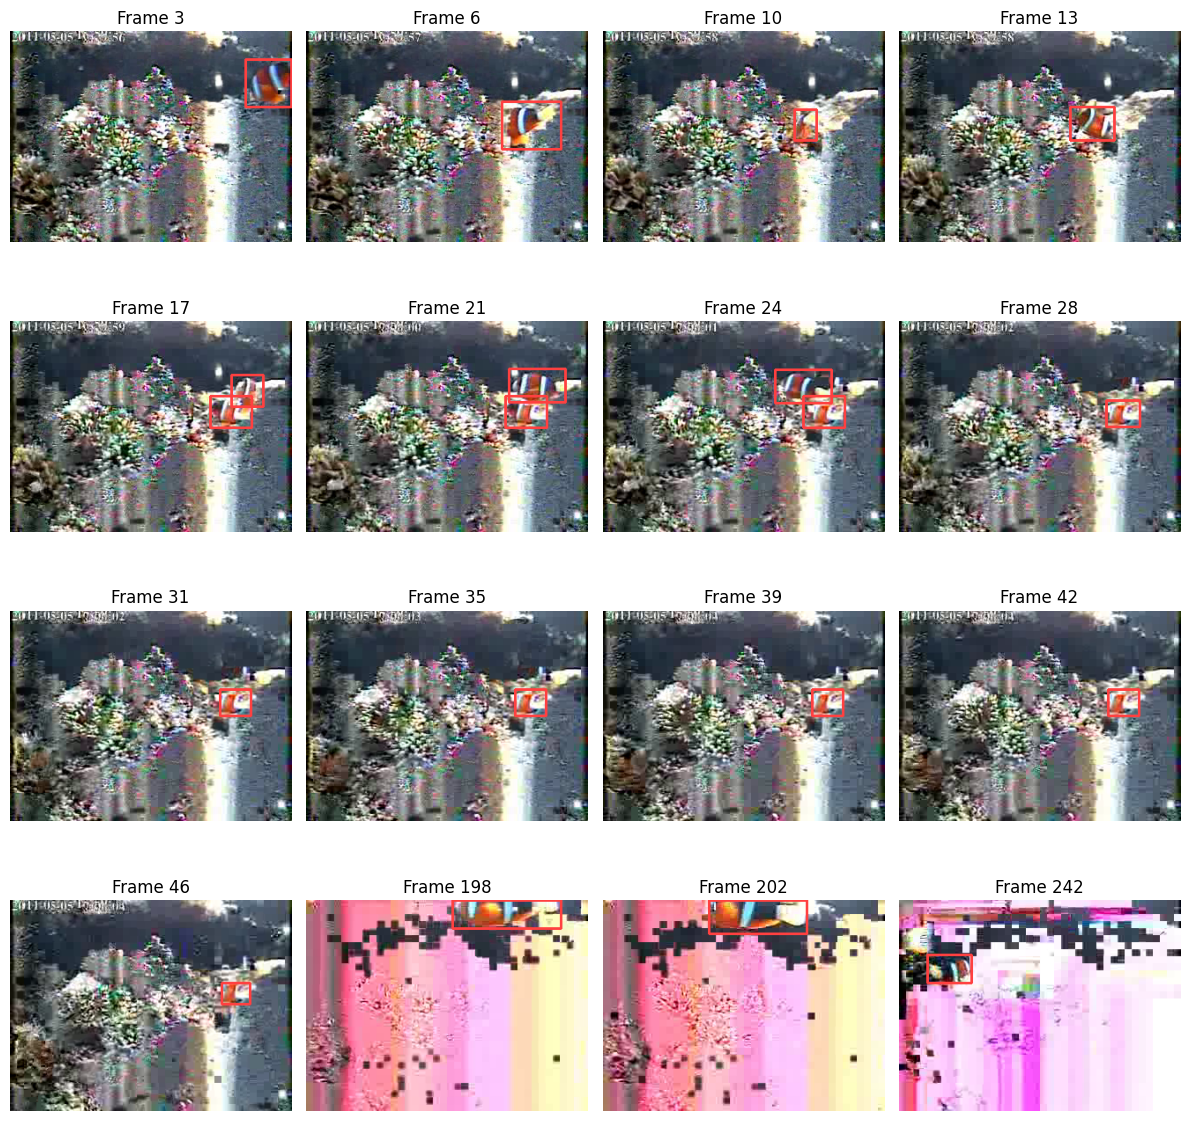

In [21]:
video_files = glob.glob(os.path.join(training_videos_path, "*.flv"))
video_file = random.choice(video_files)
coco_annotations = training_annotations_coco_path + "/" + os.path.splitext(os.path.basename(video_file))[0] + ".json"
print(f"Video file: {video_file}")
visualize_annotated_frames_grid(video_file, coco_annotations)

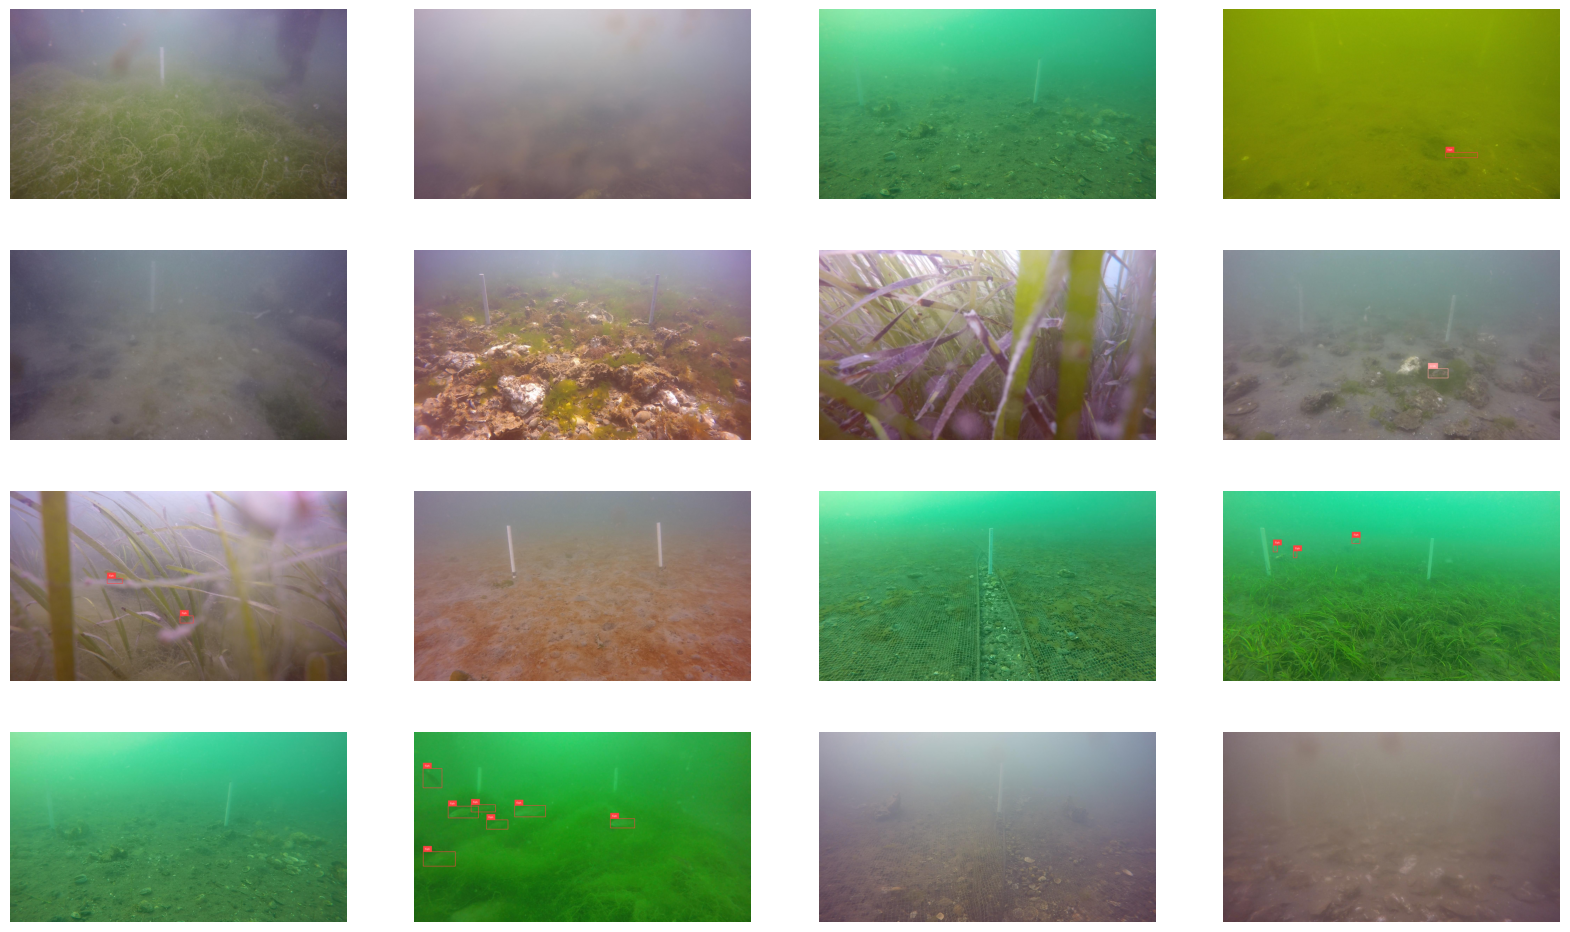

In [34]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

image_example = None

annotated_images = []
for _ in range(16):
    i = random.randint(0, len(dataset))
    
    _, image, annotations = dataset[i]

    labels = [dataset.classes[class_id] for class_id in annotations.class_id]

    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels)
    annotated_images.append(annotated_image)
    
    if len(annotations) > 0:
        image_example = annotated_image
    
sv.plot_images_grid(
    annotated_images,
    grid_size=(4, 4),
    titles=None,
    size=(20, 12),
    cmap="gray"
)

plt.imsave(f"data_preview/{dataset_shortname}_sample_image.png", image_example)


## Save Output
- Save example image
- Save notebook to visualize the image